In [4]:
import os
import random
import sys
import subprocess
from operator import itemgetter

import re
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import gensim

from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Activation, Input, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.recurrent import GRU,LSTM
from keras.layers.pooling import MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Dot,Concatenate
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.mlab as mlab
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

## Word analysis with Old English poetry corpus
This notebook works with the Old English poetry corpus made publicly available by  Murray McGillivray at the University of Calgary (http://people.ucalgary.ca/~mmcgilli/OEPoetry/)

* basic word analyses
* simple embeddings
* phonological distance for comparing words

### Read in Old English poetry corpus 

In [6]:
# read in all the poems 
path = '/Users/ChadMorgan/Documents/old_english/OldEnglishPoetryCorpus/scraped_corpus'
contents = os.listdir(path)

In [4]:
for poem in contents:
    print(poem)

a_prayer.txt
a_proverb_from_winfrids_time.txt
a_summons_to_prayer.txt
aldhelm.txt
almsgiving.txt
an_exhortation_to_christian_living.txt
andreas.txt
azarias.txt
bedes_death_song_northumbrian_version.txt
bedes_death_song_the_hague_version.txt
bedes_death_song_west_saxon_version.txt
beowulf.txt
caedmons_hymn_northumbrian_version.txt
caedmons_hymn_west_saxon_version.txt
christ_a_b_c.txt
christ_and_satan.txt
daniel.txt
deor.txt
durham.txt
elene.txt
exodus.txt
fragments_of_psalms_psalm_101.txt
fragments_of_psalms_psalm_102.txt
fragments_of_psalms_psalm_118.txt
fragments_of_psalms_psalm_121.txt
fragments_of_psalms_psalm_139.txt
fragments_of_psalms_psalm_140.txt
fragments_of_psalms_psalm_19.txt
fragments_of_psalms_psalm_24.txt
fragments_of_psalms_psalm_27.txt
fragments_of_psalms_psalm_32.txt
fragments_of_psalms_psalm_34.txt
fragments_of_psalms_psalm_40.txt
fragments_of_psalms_psalm_43.txt
fragments_of_psalms_psalm_5.txt
fragments_of_psalms_psalm_50.txt
fragments_of_psalms_psalm_53.txt
fragment

#### Example poem: Wuld and Eadwacer

In [199]:
print("Wulf and Eadwacer\n")
poem_text_raw = open(path+'/'+"wulf_and_eadwacer.txt").read()
poem_lines = re.split("\.|\!|\?|\;",poem_text_raw)
for line in poem_lines:
    # remove punctuation and extra whitespace
    line = re.sub("\.|\:|\!|\,|\n|\;",'',line)
    line = re.sub("$ | ^",'',line)
    line_tokens = line.split(' ')
    line_tokens_clean = []
    for l in line_tokens:
        if l != '':
            # use of q is only in latin loanwords. 
            # xx should only occur in roman numerals
            if re.search('q',l) or re.search('xx',l):
                continue
            # valid words must contain a vowel
            elif re.search("['y','i','u','e','o','æ','a']",l):
                line_tokens_clean += [l]
    print(line_tokens_clean)

Wulf and Eadwacer

['leodum', 'is', 'minum', 'swylce', 'him', 'mon', 'lac', 'gife']
['willað', 'hy', 'hine', 'aþecgan', 'gif', 'he', 'on', 'þreat', 'cymeð']
['ungelic', 'is', 'us']
['wulf', 'is', 'on', 'iege', 'ic', 'on', 'oþerre']
['fæst', 'is', 'þæt', 'eglond', 'fenne', 'biworpen']
['sindon', 'wælreowe', 'weras', 'þær', 'on', 'ige']
['willað', 'hy', 'hine', 'aþecgan', 'gif', 'he', 'on', 'þreat', 'cymeð']
['ungelice', 'is', 'us']
['wulfes', 'ic', 'mines', 'widlastum', 'wenum', 'hogode']
['þonne', 'hit', 'wæs', 'renig', 'weder', 'ond', 'ic', 'reotugu', 'sæt', 'þonne', 'mec', 'se', 'beaducafa', 'bogum', 'bilegde', 'wæs', 'me', 'wyn', 'to', 'þon', 'wæs', 'me', 'hwæþre', 'eac', 'lað']
['wulf', 'min', 'wulf', 'wena', 'me', 'þine', 'seoce', 'gedydon', 'þine', 'seldcymas', 'murnende', 'mod', 'nales', 'meteliste']
['gehyrest', 'þu', 'eadwacer', 'uncerne', 'earmne', 'hwelp', 'bireð', 'wulf', 'to', 'wuda']
['þæt', 'mon', 'eaþe', 'tosliteð', 'þætte', 'næfre', 'gesomnad', 'wæs', 'uncer', 'giedd',

#### Read in all poems and save list of sentences

In [10]:
corpus_lines = []
token_set = set()
token_dict = {}
poem_line_ct = []

# contents0 = [
#              "beowulf.txt",
#             "the_wanderer.txt","the_seafarer.txt","widsith.txt"
#              ,"the_dream_of_the_rood.txt","judith.txt","the_battle_of_maldon.txt"
#              ,"the_descent_into_hell.txt","the_wifes_lament.txt"
#              ,"the_husbands_message.txt","aldhelm.txt","andreas.txt"
#              ,"deor.txt","christ_and_satan.txt","durham.txt"
#              ,"caedmons_hymn_west_saxon_version.txt","wulf_and_eadwacer.txt"]
# for poem in contents0:
for poem in contents:
    # read full poem and split into sentences / independent clauses
    poem_text_raw = open(path+'/'+poem).read()
    poem_lines = re.split("\.|\!|\?|\;",poem_text_raw)
    poem_line_ct += [(poem,len(poem_lines))]
    for line in poem_lines:
        # remove punctuation and extra whitespace
        line = re.sub("\.|\:|\!|\,|\n|\;",'',line)
        line = re.sub("$ | ^",'',line)
        line_tokens = line.split(' ')
        line_tokens_clean = []
        for l in line_tokens:
            if l != '':
                # use of q is only in latin loanwords. 
                # xx should only occur in roman numerals
                if re.search('q',l) or re.search('xx',l):
                    continue
                # valid words must contain a vowel
                elif re.search("['y','i','u','e','o','æ','a']",l):
                    line_tokens_clean += [l]
                    if l not in token_set:
                        token_dict[l] = 1
                        token_set.add(l)
                    else:
                        token_dict[l] += 1
        if len(line_tokens_clean)>0:
            corpus_lines += [line_tokens_clean]

            
flat_tokens = [item for sublist in corpus_lines for item in sublist]            

In [11]:
print("total sentences:",len(corpus_lines))
print("total words:",len(flat_tokens))
print("unique words:",len(token_set))
print("\nTop poems by number of sentences:")
sorted(poem_line_ct,key=itemgetter(1),reverse=True)[0:25]

total sentences: 10969
total words: 175055
unique words: 26993

Top poems by number of sentences:


[('beowulf.txt', 1170),
 ('genesis.txt', 1062),
 ('andreas.txt', 569),
 ('christ_a_b_c.txt', 518),
 ('guthlac_a_b.txt', 449),
 ('elene.txt', 368),
 ('christ_and_satan.txt', 290),
 ('the_paris_psalter_psalm_118.txt', 256),
 ('daniel.txt', 236),
 ('exodus.txt', 217),
 ('juliana.txt', 215),
 ('the_phoenix.txt', 197),
 ('solomon_and_saturn.txt', 187),
 ('the_battle_of_maldon.txt', 141),
 ('the_descent_into_hell.txt', 138),
 ('maxims_i.txt', 127),
 ('judith.txt', 108),
 ('the_husbands_message.txt', 89),
 ('the_meters_of_boethius_meter_20.txt', 86),
 ('the_paris_psalter_psalm_77.txt', 84),
 ('riddle_84.txt', 83),
 ('the_dream_of_the_rood.txt', 79),
 ('the_judgment_day_ii.txt', 79),
 ('the_mologium.txt', 63),
 ('widsith.txt', 63)]

## Simple word analyses

### Most common words

In [12]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
print("Top words by frequency:")
print(token_count.head(10))

print("Unique words:",len(token_count))
print("Words with one occurence:",len(token_count[token_count['freq']==1]))

token_count = token_count.reset_index()

Top words by frequency:
  token  freq
0    on  4380
1   and  3177
2   þæt  2913
3    þa  2168
4    ic  2091
5   ond  2055
6    he  1943
7    þe  1930
8    ne  1867
9    to  1813
Unique words: 26993
Words with one occurence: 16047


In [38]:
print(token_count[token_count['token']=='hwæt'])
print(token_count[token_count['token']=='as'])

    index token  freq  token_len
61     61  hwæt   271          4
Empty DataFrame
Columns: [index, token, freq, token_len]
Index: []


### Rank vs. frequency of word (Zipf's law)

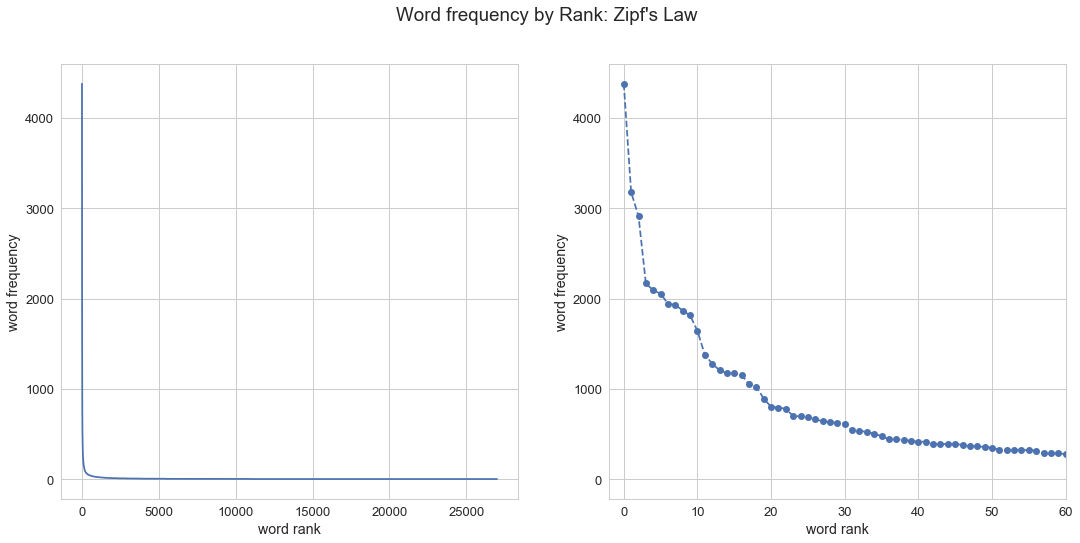

In [13]:
plt.figure(figsize=(18, 8))
plt.suptitle("Word frequency by Rank: Zipf's Law")
plt.subplot(121)
plt.plot(token_count['index'],token_count['freq'])
plt.xlabel('word rank')
plt.ylabel('word frequency')
plt.subplot(122)
plt.plot(token_count['index'],token_count['freq'],linestyle='--', marker='o')
plt.xlim([-2,60])
plt.xlabel('word rank')
plt.ylabel('word frequency')

### Word lengths

count    26993.000000
mean         7.238803
std          2.231347
min          1.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         20.000000
Name: token_len, dtype: float64


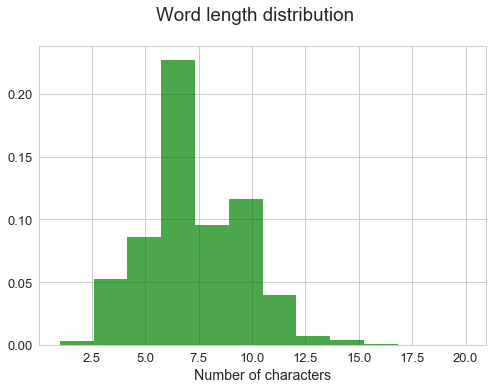

In [14]:
token_count['token_len'] = token_count['token'].apply(lambda x: len(x))
print(token_count['token_len'].describe())
n, bins, patches = plt.hist(token_count['token_len'], 12, normed=1, facecolor='green', alpha=0.7)
plt.suptitle('Word length distribution')
plt.xlabel('Number of characters')

[3, 3, 4, 6, 23]


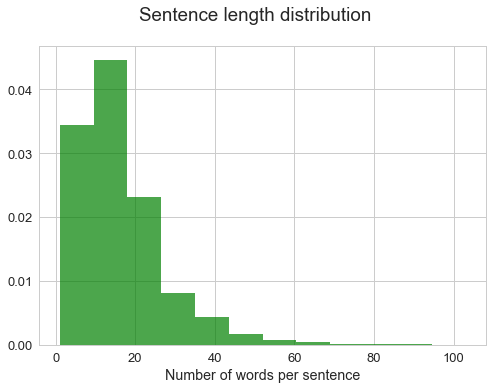

In [15]:
line_length = []
for l in corpus_lines:
    line_length += [len(l)]
print(line_length[0:5])

n, bins, patches = plt.hist(line_length, 12, normed=1, facecolor='green', alpha=0.7)
plt.suptitle('Sentence length distribution')
plt.xlabel('Number of words per sentence')

In [40]:
corpus_lines[0:3]

[['æla', 'drihten', 'leof'],
 ['æla', 'dema', 'god'],
 ['geara', 'me', 'ece', 'waldend']]

In [16]:
model = gensim.models.Word2Vec(size=80, window=7, min_count=3,iter=30,sg=1)
model.build_vocab(corpus_lines)
model.train(corpus_lines,total_examples=model.corpus_count,epochs=model.iter)

3764391

In [18]:
print(token_count[token_count["token"]=="ellen"])
model.wv.most_similar(positive=['ellen'])

     index  token  freq  token_len
634    634  ellen    34          5


[('colað', 0.6808252334594727),
 ('eafoð', 0.6286718845367432),
 ('geþoht', 0.6000107526779175),
 ('gena', 0.5743659734725952),
 ('dohte', 0.5610024929046631),
 ('gesingan', 0.5588849782943726),
 ('gemunað', 0.5495438575744629),
 ('lofes', 0.5474838018417358),
 ('dreorigne', 0.539673924446106),
 ('heofoncyninge', 0.5346117615699768)]

### Character distances based on Old English phonology and orthography

See https://en.wikipedia.org/wiki/Old_English_phonology 
if you are unfamiliar with the Old English characters 
and sound system

In [19]:
#  ---- define Old English vowels

# ------------------------------------------
#
#       front                back
# close  i : y ------------ : u
#           \                |
#     mid   e:  -----------  : o
#             \              |
#      open   æ:  --------- a :
#
# ------------------------------------------

vowels = ['y','i','u','e','o','æ','a']

# features (dim = 3): 
#    close (1) vs. mid (.5) open (0)
#    front (1) vs. back (0)
#    rounded (0.25) vs. rounded (0)

vowel_ft = {}
vowel_ft['y'] = [1,1,0.25]
vowel_ft['i'] = [1,1,0]
vowel_ft['u'] = [1,0,0.25]
vowel_ft['e'] = [0.5,1,0]
vowel_ft['o'] = [0.5,0,0.25]
vowel_ft['æ'] = [0,1,0]
vowel_ft['a'] = [0,0,0]

In [20]:
#  ---- define Old English consonants

# standard set of OE consonant characters
consonants = ['n','r','s','d','l','g','t','m','h'
                  ,'w','f','þ','b','p'            
            # ʃ here for the fricative sound spelled "sc" in OE
                  ,'ʃ'
            # j here for the fricative sound spelled "cg"
                 ,'j'
            # OE used letter c for hard c and assibilated "ch" sound
            # we will use c for ME 'ch' and k for the hard sound
              ,'c','k'
             ]

print(sorted(consonants))
consonants = set(consonants)

['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'w', 'þ', 'ʃ']


In [21]:
# alter token to reflect pronunciation using OE orthography rules
def orthog_sub(string):# remove doubled letters
    # replace bigraphs with one character
    string = re.sub('sc','ʃ',string) # OE "sc" is like ME "sh"
    string = re.sub('cg','j',string) # OE "cg" is like ME "j"
    string = re.sub('uu','w',string) # in some dialects "w" is "uu"
    string = re.sub('x','ks',string) # x is two consonants ks: break down
    # þ and ð are interchangable in OE
    string = re.sub('ð','þ',string) 
    for i,c in enumerate(string):  
        string = re.sub(c+"+",c,string)
    string0 = ''
    for i,c in enumerate(string):  
        if c == "c":
            if i+1==len(string):
                string0 += "k"
            # before e and i c is "assibilated" ME ch sound
            elif string[i+1] not in set(['e','i']):
                # represent stop with k, fricative with c
                string0 += "k"
            else: 
                string0 += c
        else: 
            string0 += c
    return(string0)

print(orthog_sub('biscop'))
print(orthog_sub('ecgþeow'))
print(orthog_sub('uuldurfadur'))
print(orthog_sub('wiccecræft'))
print(orthog_sub('hwylcum'))

biʃop
ejþeow
wldurfadur
wicekræft
hwylkum


In [22]:
# consonant features (dim = 3):
# 0: voicing (0 = unvoiced, .1 = voiced)
# 1: place: (labial=0, dental=.15, alveolar=.3, post-alveolar=.45, 
#            palatal=.6, velar=.75, glottal=.9 ) 
# -- manner:
# 2: nasal
# 3: stop
# 4: fricative
# 5: approximant
# 6: trill 

consonant_ft = {}

# --- nasals (voiced) --- #
consonant_ft['m'] = [.1,0,1,0,0,0,0]
consonant_ft['n'] = [.1,.3,1,0,0,0,0]

# --- stops --- #
consonant_ft['p'] = [0,0,0,1,0,0,0]
consonant_ft['b'] = [.1,0,0,1,0,0,0]
consonant_ft['t'] = [0,.3,0,1,0,0,0]
consonant_ft['d'] = [.1,.3,0,1,0,0,0]
consonant_ft['k'] = [0,.75,0,1,0,0,0]
consonant_ft['g'] = [.1,.75,.0,1,0,0,0]

# --- fricatives --- #
consonant_ft['f'] = [.1,0,0,0,1,0,0]
consonant_ft['þ'] = [.1,.15,0,0,1,0,0]
consonant_ft['s'] = [.1,.3,0,0,1,0,0]
consonant_ft['ʃ'] = [.1,.45,0,0,1,0,0]
consonant_ft['c'] = [.1,.6,0,0,1,0,0]
consonant_ft['h'] = [.1,.9,0,0,1,0,0]

# --- approximants --- #
consonant_ft['l'] = [.1,.3,0,0,0,1,0]
consonant_ft['j'] = [.1,.6,0,0,0,1,0]
consonant_ft['w'] = [.1,.75,0,0,0,1,0]

# --- trill --- # 
consonant_ft['r'] = [.1,.3,0,0,0,0,1]

count    10342.000000
mean         6.801199
std          2.193415
min          1.000000
25%          5.000000
50%          7.000000
75%          8.000000
max         15.000000
Name: token_trans_len, dtype: float64


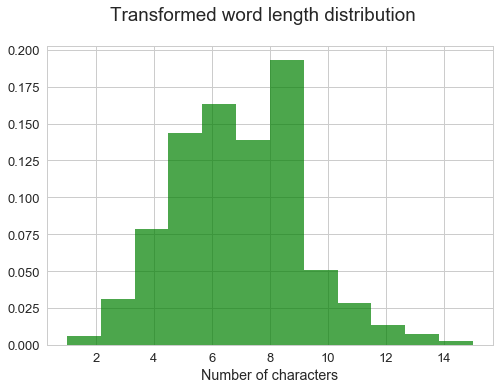

In [108]:
token_count['token_trans_len'] = token_count['token'].apply(lambda x: len(orthog_sub(x)))
print(token_count['token_trans_len'].describe())
n, bins, patches = plt.hist(token_count['token_trans_len'], 12, normed=1, facecolor='green', alpha=0.7)
plt.suptitle('Transformed word length distribution')
plt.xlabel('Number of characters')

### Function for converting token into sequence of phonological features

In [109]:
char_index_dict = {}
index_char_dict = {}
char_ft_matrix = [[0] * 10]

chars = list(vowels) + list(consonants)
for i,c in enumerate(chars):
    char_index_dict[c] = i+1
    index_char_dict[i+1] = c
    if c in vowels:
            c_ft = vowel_ft[c] + [0,0,0,0,0,0,0]
    elif c in consonants:
        c_ft = [0,0,0] + consonant_ft[c]
    char_ft_matrix.append(c_ft)
char_ft_matrix = np.array(char_ft_matrix)
char_ft_matrix

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  1.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.5 ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.5 ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.1 ,  0.45,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.1 ,  0.75,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.1 ,  0.6 ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.1 ,  0.3 ,  0.  ,  0

In [110]:
def token_to_feature_seq(token,pad_length):
    token = orthog_sub(token)
    token_len = len(token)
    if token_len<pad_length:
        token = "0" * (pad_length-token_len) + token
    char_seq = []
    for c in token:
        if c == "0":
            c_idx = 0
        else:
            c_idx = char_index_dict[c]
        char_seq.append(c_idx)
    char_seq = np.array(char_seq)
    return(char_seq)

In [111]:
print(orthog_sub("wiccecræft"))
token_to_feature_seq("wiccecræft",15)

wicekræft


array([ 0,  0,  0,  0,  0,  0, 16,  2, 14,  4, 24, 12,  6, 25, 15])

### Character level skipgram

In [212]:
print(token_count.head())
index_token_dict = pd.Series(token_count.token.values,index=token_count.index).to_dict()
token_index_dict = pd.Series(token_count.index.values,index=token_count.token).to_dict()
token_index_dict["ic"]

   index token  freq
0      0    on   894
1      1   þæt   758
2      2   ond   687
3      3    þa   570
4      4    he   560


6

In [113]:
# create tokenized sequences from each sentence in corpus
tokenized_corpus = []
for l in corpus_lines:
    line_token_idx = []
    for t in l:
        line_token_idx += [token_index_dict[t]]
    if len(line_token_idx)>1:
        tokenized_corpus += [line_token_idx]

print(corpus_lines[1])
print(tokenized_corpus[1])
print(len(tokenized_corpus))

V = len(token_set)+1
print(V)

['we', 'gardena', 'in', 'geardagum', 'þeodcyninga', 'þrym', 'gefrunon', 'hu', 'ða', 'æþelingas', 'ellen', 'fremedon']
[53, 1273, 7953, 7952, 7951, 702, 2993, 7950, 2409, 7949, 446, 60, 169, 42, 1489, 7948]
2635
10343


In [133]:
# use skipgram context sampling to generate training pairs
target_x = []
context_x = []
target_wordidx_x = []
context_wordidx_x = []

y = []
for i, doc in enumerate(shuffle(tokenized_corpus)):
    data, labels = skipgrams(sequence=doc, vocabulary_size=V
                             ,window_size=5, negative_samples=5.)

    for j,pair in enumerate(data):
        try:
            target_seq = token_to_feature_seq(index_token_dict[pair[0]],15)
            context_seq = token_to_feature_seq(index_token_dict[pair[1]],15)
            target_x.append(target_seq)
            context_x.append(context_seq)
            target_wordidx_x.append(pair[0])
            context_wordidx_x.append(pair[1])
            y.append(labels[j])
        except KeyError:
            continue

print(len(target_x))
print(len(context_x))
print(len(y))

print(target_x[0])
print(context_x[0])

1870033
1870033
1870033
[ 0  0  0  0  0  0  0  0  0  0  9  3 17  3 22]
[ 0  0  0  0  0  0  0  0  0 25  5 12 17  7 22]


In [137]:
# train / validation split
target_x_train,target_x_valid, \
target_wordidx_train,target_wordidx_valid, \
context_x_train, context_x_valid, \
context_wordidx_train,context_wordidx_valid, \
y_train, y_valid = train_test_split(target_x,target_wordidx_x,context_x,context_wordidx_x,y,test_size = 0.2)

In [138]:
print(len(target_x_train))
print(len(target_x_valid))
print(len(context_x_train))
print(len(context_wordidx_train))
print(len(y_train))

1496026
374007
1496026
1496026
1496026


In [139]:
# convert everything to arrays
target_x_train = np.array(target_x_train)
target_x_valid = np.array(target_x_valid)
target_wordidx_train = np.array(target_wordidx_train)
target_wordidx_valid = np.array(target_wordidx_valid)
context_x_train = np.array(context_x_train)
context_x_valid = np.array(context_x_valid)
context_wordidx_train = np.array(context_wordidx_train)
context_wordidx_valid = np.array(context_wordidx_valid)

print(target_x_train.shape)
print(context_x_train.shape)

(1496026, 15)
(1496026, 15)


### Word-level skipgram embedding for benchmark

In [177]:
dim_embedddings = 128

# target word
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

# context word
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

# output: dot product of target and context vectors
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)
o = Activation('sigmoid')(o)

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
SkipGram.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_20 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_21 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_19 (Embedding)         (None, 1, 128)        1323904     input_20[0][0]                   
____________________________________________________________________________________________________
embedding_20 (Embedding)         (None, 1, 128)        1323904     input_21[0][0]                   
___________________________________________________________________________________________

In [178]:
%%time
hist_word_sg = SkipGram.fit([target_wordidx_train, context_wordidx_train],
                     y_train,
                     batch_size=32, 
                     epochs=10, 
                     verbose=1,
                     validation_data=([target_wordidx_valid,context_wordidx_valid]
                                      ,y_valid))

Train on 1496026 samples, validate on 374007 samples
Epoch 1/10
1496026/1496026 [==============================] - 1573s - loss: 0.4164 - acc: 0.8640 - val_loss: 0.4269 - val_acc: 0.8856
Epoch 2/10
1496026/1496026 [==============================] - 1564s - loss: 0.3709 - acc: 0.8999 - val_loss: 0.4345 - val_acc: 0.8849
Epoch 3/10
1496026/1496026 [==============================] - 1521s - loss: 0.2817 - acc: 0.9253 - val_loss: 0.4488 - val_acc: 0.8809
Epoch 4/10
1496026/1496026 [==============================] - 1465s - loss: 0.2102 - acc: 0.9448 - val_loss: 0.4707 - val_acc: 0.8783
Epoch 5/10
1496026/1496026 [==============================] - 1470s - loss: 0.1641 - acc: 0.9567 - val_loss: 0.5018 - val_acc: 0.8765
Epoch 6/10
1496026/1496026 [==============================] - 1469s - loss: 0.1350 - acc: 0.9634 - val_loss: 0.5322 - val_acc: 0.8760
Epoch 7/10
1496026/1496026 [==============================] - 1474s - loss: 0.1164 - acc: 0.9677 - val_loss: 0.5637 - val_acc: 0.8757
Epoch 8/1

### Convolutional model on character sequence

In [179]:
## word's character sequence input
target_seq_input = Input(shape=(15,),dtype='float32')
target_char_embed = Embedding(input_dim=26
                      ,output_dim=10
                      ,weights=[char_ft_matrix]
                     ,trainable=False
                     ,mask_zero=False)(target_seq_input)

context_seq_input = Input(shape=(15,),dtype='float32')
context_char_embed = Embedding(input_dim=26
                      ,output_dim=10
                      ,weights=[char_ft_matrix]
                     ,trainable=False
                     ,mask_zero=False)(context_seq_input)
print(context_char_embed.shape)

(?, 15, 10)


In [180]:
# convolutional and pooling layers

convnet3 = Sequential()
convnet3.add(Conv1D(filters=128,kernel_size=1,input_shape=(15,10,)))
convnet3.add(BatchNormalization(axis=1,scale=False))
convnet3.add(Activation("relu"))
convnet3.add(Conv1D(filters=128,kernel_size=3))
convnet3.add(BatchNormalization(axis=1,scale=False))
convnet3.add(Activation("relu"))
convnet3.add(MaxPooling1D(2))
convnet3.add(Flatten())
convnet3.add(Dense(256))
convnet3.add(BatchNormalization(axis=1,scale=False))
convnet3.add(Activation("relu"))
    
# apply same convnet to both inputs (so the weights will be shared)
encoded_target = convnet3(target_char_embed)
encoded_context = convnet3(context_char_embed)

In [181]:
# Add dense layer for target and context embedding
target_embed = Dense(128,name="encoded_target")(encoded_target)
print(target_embed.shape)
context_embed = Dense(128)(encoded_context)
print(context_embed.shape)

# Output: dot product of target / context vectors, sigmoid activation
output = Dot(axes=1)([target_embed, context_embed])
print(output.shape)
output = Reshape((1,), input_shape=(1,1))(output)
output = Activation('sigmoid')(output)

CharSkipGram = Model(inputs=[target_seq_input, context_seq_input], outputs=output)
CharSkipGram.summary()
CharSkipGram.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

(?, 128)
(?, 128)
(?, 1)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 15)            0                                            
____________________________________________________________________________________________________
input_23 (InputLayer)            (None, 15)            0                                            
____________________________________________________________________________________________________
embedding_21 (Embedding)         (None, 15, 10)        260         input_22[0][0]                   
____________________________________________________________________________________________________
embedding_22 (Embedding)         (None, 15, 10)        260         input_23[0][0]                   
__________________________________________________________________

In [182]:
%%time
hist_sg = CharSkipGram.fit([target_x_train, context_x_train],
                     y_train,
                     batch_size=32, 
                     epochs=10, 
                     verbose=1,
                     validation_data=([target_x_valid,context_x_valid]
                                      ,y_valid))

Train on 1496026 samples, validate on 374007 samples
Epoch 1/10
1496026/1496026 [==============================] - 3681s - loss: 0.3990 - acc: 0.8640 - val_loss: 0.4140 - val_acc: 0.8369
Epoch 2/10
1496026/1496026 [==============================] - 3708s - loss: 0.3550 - acc: 0.8713 - val_loss: 0.3716 - val_acc: 0.8628
Epoch 3/10
1496026/1496026 [==============================] - 3687s - loss: 0.3500 - acc: 0.8725 - val_loss: 0.3605 - val_acc: 0.8675
Epoch 4/10
1496026/1496026 [==============================] - 4034s - loss: 0.3469 - acc: 0.8735 - val_loss: 0.3585 - val_acc: 0.8680
Epoch 5/10
1496026/1496026 [==============================] - 3714s - loss: 0.3448 - acc: 0.8737 - val_loss: 0.3473 - val_acc: 0.8720
Epoch 6/10
1496026/1496026 [==============================] - 3729s - loss: 0.3436 - acc: 0.8739 - val_loss: 0.3542 - val_acc: 0.8697
Epoch 7/10
1496026/1496026 [==============================] - 3725s - loss: 0.3425 - acc: 0.8741 - val_loss: 0.3504 - val_acc: 0.8711
Epoch 8/1

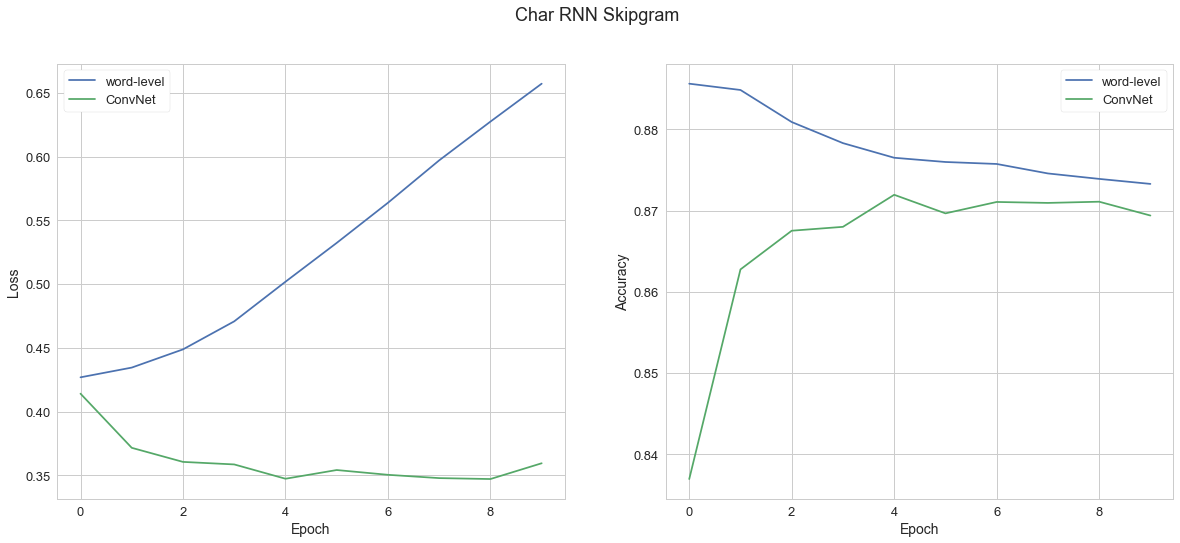

In [185]:
plt.figure(figsize=(20, 8))
plt.suptitle("Char RNN Skipgram", fontsize=18)
plt.subplot(121)
plt.plot(hist_word_sg.history["val_loss"], label="word-level")
plt.plot(hist_sg.history["val_loss"], label="ConvNet")
#plt.plot(hist_rnnsg.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(hist_word_sg.history["val_acc"], label="word-level")
plt.plot(hist_sg.history["val_acc"], label="ConvNet")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [186]:
embed_extract = Model(input=[target_seq_input]
                      , output=CharSkipGram.get_layer("encoded_target").output)

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("en...)`
  


In [213]:
w_ft_matrix = []
for w in token_index_dict.keys():
    try:
        w_ft_matrix.append(token_to_feature_seq(w,15))
    except KeyError:
        print(w)

char_sg_embed = embed_extract.predict(np.array(w_ft_matrix))

In [215]:
char_sg_embed.shape

(10342, 128)

In [2]:
#def most_similar(word,embeddings):
word = "cyning"
embeddings = char_sg_embed
target_embed = embeddings[token_index_dict[word]]

sims = cosine_similarity(target_embed,embeddings)
    


NameError: name 'char_sg_embed' is not defined

In [1]:
sims.length

NameError: name 'sims' is not defined

### Recurrent model on character sequence

In [162]:
recurrent = Sequential()
recurrent.add(LSTM(128,input_shape=(15,10,)))
    
RNN_encoded_target = recurrent(target_char_embed)
RNN_encoded_context = recurrent(context_char_embed)

In [163]:
# Add dense layer for target and context embedding
RNN_target_embed = Dense(128,name="encoded_target")(RNN_encoded_target)
print(RNN_target_embed.shape)
RNN_context_embed = Dense(128)(RNN_encoded_context)
print(RNN_context_embed.shape)

# Output: dot product of target / context vectors, sigmoid activation
RNN_output = Dot(axes=1)([RNN_target_embed, RNN_context_embed])
print(RNN_output.shape)
RNN_output = Reshape((1,), input_shape=(1,1))(RNN_output)
RNN_output = Activation('sigmoid')(RNN_output)

RNNCharSkipGram = Model(inputs=[target_seq_input, context_seq_input], outputs=RNN_output)
RNNCharSkipGram.summary()
RNNCharSkipGram.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

(?, 128)
(?, 128)
(?, 1)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 15)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 15)            0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 15, 10)        260         input_3[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 15, 10)        260         input_4[0][0]                    
__________________________________________________________________

In [205]:
# %%time
# hist_rnnsg = RNNCharSkipGram.fit([target_x_train, context_x_train],
#                      y_train,
#                      batch_size=16, 
#                      epochs=5, 
#                      verbose=1,
#                      validation_data=([target_x_valid,context_x_valid]
#                                       ,y_valid))